In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import torch

#Задал рандом сиды в начале своего ноутбука.
random.seed(3)
np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)
torch.backends.cudnn.deterministic = True


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
# print('After zip extraction:')
# print(os.listdir("/kaggle/working/"))

In [ ]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

In [ ]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

In [ ]:
!ls train

In [ ]:
# import torch
# import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
#######
import albumentations as albu
from albumentations.pytorch import ToTensor


#Долго подбирал параметры аугментации изображения.
#Дольше всего старался подобрать хорошие параметры в колор джиттере. Особенно насыщение.Мне это помогло

#My_alby_transh_exaample

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(214),
    #transforms.ColorJitter(0.45,0.45,0.15,0.25), # test resnet 152 best
    transforms.ColorJitter(0.65,0.65,0.15,0.25), # test
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10),
    transforms.RandomGrayscale(p=0.05),
    #transforms.RandomVerticalFlip(),#test
    #transforms.RandomResizedCrop(size=224), #test
    #torchvision.transforms.RandomGrayscale(p=0.05), #test
    #transforms.RandomRotation(90), #test
    #transforms.FiveCrop(224),
    #transforms.Grayscale(num_output_channels=3), #test
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((234, 234)),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [ ]:
len(train_dataloader), len(train_dataset)

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

In [ ]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [ ]:
train_accuracy_history = []
train_loss_history = []
val_accuracy_history = []
val_loss_history = []
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            if phase == 'val' and epoch_acc >= 1.0: #1.0
                print("Good Model!")
                val_accuracy_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)  
#Все точности и лосы складывал в лист для рисования графиков.
            elif phase == 'val':
                val_accuracy_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)  
            else:
                train_accuracy_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)                
                
            
    return model

In [ ]:
#pip install git+https://github.com/pytorch/vision

In [ ]:
#pip install efficientnet_pytorch
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True)
squeezenet = models.squeezenet1_0(pretrained=True) #not good
vgg16 = models.vgg16(pretrained=True)
densenet = models.densenet161(pretrained=True)
inception = models.inception_v3(pretrained=True)
googlenet = models.googlenet(pretrained=True)
shufflenet = models.shufflenet_v2_x1_0(pretrained=True) #can_try
mobilenet = models.mobilenet_v2(pretrained=True)
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
#wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
#mnasnet = models.mnasnet1_0(pretrained=True)

In [ ]:
#import efficientnet_pytorch
#Models arch looks
#(fc): Linear(in_features=2048, out_features=1000, bias=True) - our pattern!
#model_test = models.wide_resnet101_2(pretrained=True)
#model_test = efficientnet_pytorch.model.EfficientNet
vgg16.classifier = torch.nn.Linear(25088, 2)
resnext50_32x4d

In [ ]:
#Перебрал несколько моделей из доступных в пайторче. остановился на самой лучшей
#для меня это стал Реснет-152
#resnet_tested
#google_tested

#model = models.resnet18(pretrained=True)
model = models.resnet152(pretrained=True) #best
#model = models.resnet101(pretrained=True)
#model = models.resnext101_32x8d(pretrained=True)
#model = models.googlenet(pretrained=True)
#model = models.densenet201(pretrained=True)
#model = resnext50_32x4d




# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

#model.fc = torch.nn.Linear(model.fc.in_features, 2) 
#model.classifier = torch.nn.Linear(model.classifier.in_features, 2) #densenet models
model.fc = torch.nn.Linear(model.fc.in_features, 2) #resnet,google 


weight_tensor = torch.tensor([0.5,3.5])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
weight_tensor = weight_tensor.to(device)


loss = torch.nn.CrossEntropyLoss() #
# Долго подбирал параметры оптимайзера и остановился на Адам. 
# Лернинг рейт оставил стандартный но применил amsgrad
optimizer = torch.optim.Adam(model.parameters(), lr=5 *1.0e-3, amsgrad=True)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, nesterov=True) #best
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.14, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.4, centered=False)

# Decay LR by a factor of 0.1 every 7 epochs
# Шудулер пробовал с разными параметрами и шагами. Гамму увелечили до 0.15
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.15)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer ,milestones=[30,60,90], gamma=0.3)

In [ ]:
random.seed(2)
np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed(2)
train_accuracy_history = []
train_loss_history = []
val_accuracy_history = []
val_loss_history = []
train_model(model, loss, optimizer, scheduler, num_epochs=20);

In [ ]:
plt.plot(train_accuracy_history);
plt.plot(val_accuracy_history);
# тут считал средюю по точности обучения. 
print(sum(val_accuracy_history)/len(val_accuracy_history))

In [ ]:
# test_dir = 'test'
# shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
test_dataset

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    #inputs = inputs / 255.0
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs )
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

In [ ]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [ ]:
#submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [ ]:
#submission_df.head(50)

In [ ]:
prob_val = 0.51

submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions, 'prob':test_predictions})
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > prob_val else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
#submission_df.set_index('prob', inplace=True)

# submission_df['prob']=pred
print(submission_df.prob.mean())
print(submission_df.prob.std())

print(submission_df.loc[submission_df['label']=='cleaned'].mean())
print(submission_df.loc[submission_df['label']=='cleaned'].count())
print('*********')
print(submission_df.label.value_counts())
print('************')
submission_df.loc[submission_df['label']=='cleaned']

In [ ]:
submission_df.label.value_counts()

In [ ]:
submission_df2 = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
submission_df2['label'] = submission_df2['label'].map(lambda pred: 'dirty' if pred > prob_val else 'cleaned')
submission_df2['id'] = submission_df2['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df2['id'] = submission_df2['id'].str.replace('.jpg', '')
submission_df2.set_index('id', inplace=True)
submission_df2.to_csv('submission.csv')

In [ ]:
#submit!!! PRESS CAREFULLY!!!!!!!
#%%bash
kaggle competitions submit -c platesv2 -f submission.csv -m "95_50_15r_8b_nm_prm"

In [ ]:
# Для повторяемости я оставлял у себя на компьютере уже обученные модели 
# для дальнейших экспериментов.
torch.save(model,"/kaggle/working/temodel")

In [ ]:
!rm -rf train val test

In [ ]:
#CLASSIC MODELS END#!!!!!!!!!!!!!!

In [ ]:
#Efficientnet
#install
!pip install --upgrade efficientnet-pytorch
#from efficientnet_pytorch import EfficientNet

In [ ]:
from efficientnet_pytorch import EfficientNet
model_eff_net_b5 = EfficientNet.from_pretrained('efficientnet-b4')
model_eff_net_b5._fc = torch.nn.Linear(model_eff_net_b5._fc.in_features, 2)
# model_eff_net_b5._swish = torch.nn.Linear(model_eff_net_b5._fc.in_features, 2)
model_eff_net_b5
# removed = list(model_eff_net_b5.children())[:-1]
# removed

In [ ]:
# model = models.resnet152(pretrained=True) #best
# model.fc = torch.nn.Linear(model.fc.in_features, 2)
# model

In [ ]:
#this shit only one!
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

In [ ]:

# model_eff_net_b5._fc = torch.nn.Linear(model_eff_net_b5._fc.in_features, 2)
# model_eff_net_b5 = removed

# model = models.resnet152(pretrained=True) #best
# model_eff_net_b5 = model
#model_eff_net_b5._fc = torch.nn.Linear(model_eff_net_b5._fc.in_features, 2)
for param in model_eff_net_b5.parameters():
    param.requires_grad = False
    


weight_tensor = torch.tensor([1.0,10.0])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_eff_net_b5 = model_eff_net_b5.to(device)
weight_tensor = weight_tensor.to(device)

loss = torch.nn.CrossEntropyLoss() #weight=weight_tensor
# loss.requires_grad=True
# Долго подбирал параметры оптимайзера и остановился на Адам. 
# Лернинг рейт оставил стандартный но применил amsgrad
optimizer = torch.optim.Adam(model_eff_net_b5.parameters(), lr=1 *1.0e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, nesterov=True) #best
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.14, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.4, centered=False)

# Decay LR by a factor of 0.1 every 7 epochs
# Шудулер пробовал с разными параметрами и шагами. Гамму увелечили до 0.15
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.15)

#*****************************************************************
def train_model_my(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    loss_value.requires_grad=True
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.requires_grad=True
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            if phase == 'val' and epoch_acc >= 1.0: #1.0
                print("Good Model!")
                val_accuracy_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)  
#Все точности и лосы складывал в лист для рисования графиков.
            elif phase == 'val':
                val_accuracy_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)  
            else:
                train_accuracy_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)                
                
            
    return model




#******************************************************************
random.seed(3)
np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)
train_accuracy_history = []
train_loss_history = []
val_accuracy_history = []
val_loss_history = []

train_model_my(model_eff_net_b5, loss, optimizer, scheduler, num_epochs=3)

# model_eff_net_b5.eval()
# with torch.no_grad():
#     outputs = model_eff_net_b5(img)

# features = model_eff_net_b5.extract_features(img)
# print(features.shape) # torch.Size([1, 1280, 7, 7])
#########################################


######################################
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

model_eff_net_b5.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model_eff_net_b5(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)




In [ ]:
plt.plot(train_accuracy_history);
plt.plot(val_accuracy_history);
# тут считал средюю по точности обучения. 
print(sum(val_accuracy_history)/len(val_accuracy_history))

In [ ]:
pred_val = 0.56
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions, 'prob':test_predictions})
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > pred_val else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
#submission_df.set_index('prob', inplace=True)

# submission_df['prob']=pred
print(submission_df.loc[submission_df['label']=='cleaned'].mean())
print(submission_df.loc[submission_df['label']=='cleaned'].count())
print('*********')
print(submission_df.label.value_counts())
print('************')
submission_df.loc[submission_df['label']=='cleaned']
#submission_df2.to_csv('submission.csv')

In [ ]:
submission_df2 = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
submission_df2['label'] = submission_df2['label'].map(lambda pred: 'dirty' if pred > prob_val else 'cleaned')
submission_df2['id'] = submission_df2['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df2['id'] = submission_df2['id'].str.replace('.jpg', '')
submission_df2.set_index('id', inplace=True)
submission_df2.to_csv('submission.csv')

In [ ]:
#*****************************************************************************************#

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import torch

#Задал рандом сиды в начале своего ноутбука.
random.seed(3)
np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)
torch.backends.cudnn.deterministic = True


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/platesv2/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
#*************************************************    
#custom_model_95 = torch.load("../input/model9502/095026",map_location='cpu') #,map_location='cpu'    
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))
#*************************************************   
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

['model-97177', 'model9502', 'platesv2']


100%|██████████| 21/21 [00:00<00:00, 3733.80it/s]

['train', 'test', '.DS_Store']


In [ ]:
#MASTER LAST TIME
# import torchvision
# import matplotlib.pyplot as plt
# import time
# import copy
# #######



# #Долго подбирал параметры аугментации изображения.
# #Дольше всего старался подобрать хорошие параметры в колор джиттере. Особенно насыщение.Мне это помогло

# #My_alby_transh_exaample

# from torchvision import transforms, models
# train_transforms = transforms.Compose([
#     transforms.RandomResizedCrop(214),#(214) best
#     #transforms.ColorJitter(0.45,0.45,0.15,0.25), # test resnet 152 best
#     transforms.ColorJitter(0.45,0.45,0.15,0.25), # test
#     transforms.RandomHorizontalFlip(),
#     #transforms.RandomRotation(10),
#     #transforms.RandomGrayscale(p=0.05),
#     #transforms.RandomVerticalFlip(),#test
#     #transforms.RandomResizedCrop(size=224), #test
#     #torchvision.transforms.RandomGrayscale(p=0.05), #test
#     #transforms.RandomRotation(90), #test
#     #transforms.FiveCrop(224),
#     #transforms.Grayscale(num_output_channels=3), #test
#     #transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#     #transforms.Lambda(lambda x: x[np.random.permutation(3), :, :])
# ])

# val_transforms = transforms.Compose([
#     transforms.Resize((234, 234)), #(234, 234) best ,((232, 233)) - 96370 (231, 233) - 096505,(230, 233) - 096639
#     #transforms.ColorJitter(0.45,0.45,0.0,0.0),
#     #transforms.CenterCrop(233),
#     #transforms.ColorJitter(0.1,0.1,0.05,0.05), 
#     #transforms.RandomGrayscale(p=0.03),
#     #transforms.RandomRotation(1),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#     #transforms.Lambda(lambda x: x[np.random.permutation(3), :, :])
# ])

# train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
# val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

# batch_size = 8
# train_dataloader = torch.utils.data.DataLoader(
#     train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
# val_dataloader = torch.utils.data.DataLoader(
#     val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [ ]:
custom_model_95 = torch.load("../input/model9502/095026",map_location='cpu') #,map_location='cpu'

In [27]:
import torchvision
import matplotlib.pyplot as plt
import time
import copy
#######



#Долго подбирал параметры аугментации изображения.
#Дольше всего старался подобрать хорошие параметры в колор джиттере. Особенно насыщение.Мне это помогло

#My_alby_transh_exaample

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(214),
    transforms.ColorJitter(0.45,0.45,0.15,0.25), # test
    transforms.RandomHorizontalFlip(),
    #transforms.RandomGrayscale(p=0.05),
    #transforms.RandomVerticalFlip(),#test
    #transforms.RandomResizedCrop(size=224), #test
    #torchvision.transforms.RandomGrayscale(p=0.05), #test
    #transforms.RandomRotation(90), #test
    #transforms.FiveCrop(224),
    #transforms.Grayscale(num_output_channels=3), #test
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((233, 235)), #(235, 235) - 97177    #(234, 234) best ,((232, 233)) - 96370 (231, 233) - 096505,(230, 233) - 096639
    #transforms.ColorJitter(0.45,0.45,0.0,0.0),
    #transforms.CenterCrop(233),
    #transforms.ColorJitter(0.1,0.1,0.05,0.05), 
    #transforms.RandomGrayscale(p=0.03),
    #transforms.RandomRotation(2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    #transforms.Lambda(lambda x: x[np.random.permutation(3), :, :])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [ ]:
#try oversamplings
# from sklearn.model_selection import train_test_split
# train_val_labels = [path.parent.name for train_val_files]



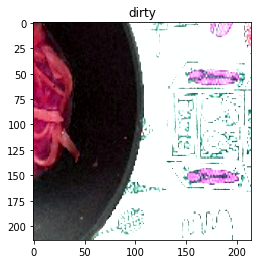

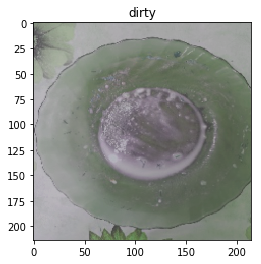

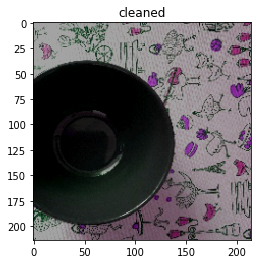

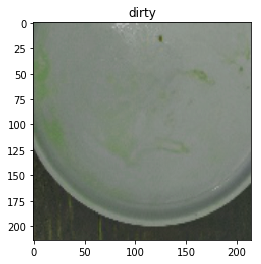

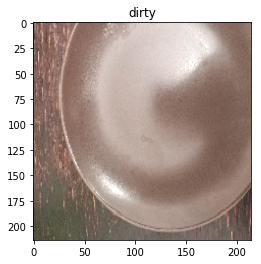

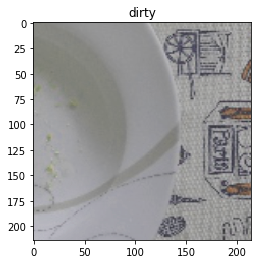

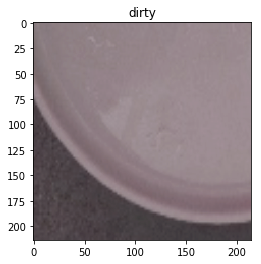

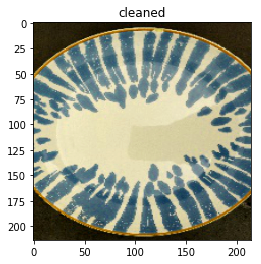

In [28]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [4]:
train_accuracy_history = []
train_loss_history = []
val_accuracy_history = []
val_loss_history = []
def my_train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            if phase == 'val' and epoch_acc >= 1.0: #1.0
                print("Good Model!")
                val_accuracy_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)  
#Все точности и лосы складывал в лист для рисования графиков.
            elif phase == 'val':
                val_accuracy_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)  
            else:
                train_accuracy_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)                
                
            
    return model

In [ ]:
# #Model block
# #model = models.resnet18(pretrained=True)
model= models.resnet152(pretrained=False) #best
# #model = models.resnet101(pretrained=True)
# #model = models.resnext101_32x8d(pretrained=True)
# model2 = models.googlenet(pretrained=True)
# model3 = models.densenet201(pretrained=True)
# #model = resnext50_32x4d




# # Disable grad for all conv layers
# for param in model2.parameters():
#     param.requires_grad = False
# for param in model3.parameters():
#     param.requires_grad = False
#********************************************
#trainn 152 from 0 with custom classifier
for param in model.parameters():
    param.requires_grad = True
    
#custom_model_95.fc_1 = torch.nn.Linear(model.fc.in_features, 512, bias=True)
# model.fc = torch.nn.Sequential(torch.nn.Linear(model.fc.in_features, 512),
#                            torch.nn.ReLU(inplace=True),
#                            torch.nn.Dropout(p=0.5, inplace=False),
#                            torch.nn.Linear(512, 256),
#                            torch.nn.ReLU(inplace=True),    
#                            torch.nn.Dropout(p=0.5, inplace=False),
#                            torch.nn.Linear(256, 2)) # посмотреть с dropout и ReLu    
    
# loss = torch.nn.CrossEntropyLoss()

# layer1 = model.layer1.parameters()
# layer2 = model.layer2.parameters()
# layer3 = model.layer3.parameters()
# layer4 = model.layer4.parameters()


# weight_tensor = torch.tensor([1.0,10.0])
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# loss = torch.nn.CrossEntropyLoss()
# found_lr = lr = 1 *1.0e-3
# optimizer = torch.optim.Adam([{'params':layer1, 'lr': found_lr / 3},
#                               {'params':layer2, 'lr': found_lr / 10},
#                               {'params':layer3, 'lr': found_lr / 50},
#                               {'params':layer4, 'lr': found_lr / 100},
#                               {'params':model.fc.parameters(),'lr': found_lr}
                                
# ], lr=found_lr/100, amsgrad=True)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.15)
#*******************************************    
    

# #model.fc = torch.nn.Linear(model.fc.in_features, 2) 
# model3.classifier = torch.nn.Linear(model3.classifier.in_features, 2) #densenet models
# model2.fc = torch.nn.Linear(model2.fc.in_features, 2) #resnet,google 

# #model.fc = torch.nn.Linear(model.fc.in_features, 2)
# model.fc2 = torch.nn.BatchNorm1d(2)
# model.fc3 = torch.nn.ReLU()
# model.fc4 = torch.nn.Dropout(p=0.4)
# model.fc4 = torch.nn.Linear(2, 2)





# weight_tensor = torch.tensor([0.5,3.5])
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# model2 = model2.to(device)
# model3 = model3.to(device)
# weight_tensor = weight_tensor.to(device)


# loss = torch.nn.CrossEntropyLoss() #
# # Долго подбирал параметры оптимайзера и остановился на Адам. 
# # Лернинг рейт оставил стандартный но применил amsgrad
# optimizer2 = torch.optim.Adam(model2.parameters(), lr=5 *1.0e-3, amsgrad=True)
# optimizer3 = torch.optim.Adam(model3.parameters(), lr=5 *1.0e-3, amsgrad=True)
# optimizer = torch.optim.Adam(model.parameters(), lr=5 *1.0e-3, amsgrad=True)
# #optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, nesterov=True) #best
# #optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0)
# #optimizer = torch.optim.RMSprop(model.parameters(), lr=0.14, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.4, centered=False)

# # Decay LR by a factor of 0.1 every 7 epochs
# # Шудулер пробовал с разными параметрами и шагами. Гамму увелечили до 0.15
# scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.15)
# scheduler3 = torch.optim.lr_scheduler.StepLR(optimizer3, step_size=7, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.15)
# #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer ,milestones=[30,60,90], gamma=0.3)
# # my_train_model(model2, loss, optimizer2, scheduler2, num_epochs=10)
# # my_train_model(model3, loss, optimizer3, scheduler3, num_epochs=10)

# random.seed(2)
# np.random.seed(2)
# torch.manual_seed(2)
# torch.cuda.manual_seed(2)
# torch.backends.cudnn.deterministic = True
# train_accuracy_history = []
# train_loss_history = []
# val_accuracy_history = []
# val_loss_history = []

# my_train_model(model, loss, optimizer, scheduler, num_epochs=150)
# model

In [ ]:
# plt.plot(train_accuracy_history);
# plt.plot(val_accuracy_history);
# # тут считал средюю по точности обучения. 
# print(sum(val_accuracy_history)/len(val_accuracy_history))

# custom_model_95.fc1 = torch.nn.ReLU()
# custom_model_95.fc2 = torch.nn.Linear(2, 2)
#custom_model_95 = torch.load("../input/model9502/095026",map_location='cpu')
# layer1 = custom_model_95.layer1.parameters()
# layer2 = custom_model_95.layer2.parameters()
# layer3 = custom_model_95.layer3.parameters()
# layer4 = custom_model_95.layer4.parameters()

In [30]:
torch.cuda.empty_cache()
#custom_model_95 = torch.load("../input/model9502/095026",map_location='cpu')
custom_model_95 = torch.load("../input/model-97177/097177_adapt_lr",map_location='cpu')
for param in custom_model_95.parameters():
    param.requires_grad = False
    
# lt=3
# cntr=0

# for child in custom_model_95.children():
#     cntr+=1

# if cntr < lt:
# 	print (child)
# 	for param in child.parameters():
# 		param.requires_grad = False
    
# for param in custom_model_95.fc.parameters():
#     param.requires_grad = False    
    
#custom_model_95.fc =  torch.nn.Linear(model.fc.in_features, 512, bias=True)

#custom_model_95.fc_1 = torch.nn.Linear(model.fc.in_features, 512, bias=True)
# custom_model_95.fc = torch.nn.Sequential(torch.nn.Linear(model.fc.in_features, 512),
#                            torch.nn.ReLU(inplace=True),
#                            torch.nn.Dropout(p=0.5, inplace=False),
#                            torch.nn.Linear(512, 256),
#                            torch.nn.ReLU(inplace=True),    
#                            torch.nn.Dropout(p=0.5, inplace=False),
#                            torch.nn.Linear(256, 2)) # посмотреть с dropout и ReLu
    
# model= models.resnet152(pretrained=False)
# for param in model.parameters():
#     param.requires_grad = False

    
# model.fc = torch.nn.Linear(model.fc.in_features, model.fc.in_features, bias=True)
# test_clf = torch.nn.Sequential(torch.nn.ReLU(inplace=True),
#                            torch.nn.Dropout(p=0.5, inplace=False),
#                            torch.nn.Linear(2048, 2048),
#                            torch.nn.ReLU(inplace=True),    
#                            torch.nn.Dropout(p=0.5, inplace=False),
#                            torch.nn.Linear(2048, 2)) # посмотреть с dropout и ReLu

# model.fc1 = test_clf
#custom_clf_model = torch.nn.Sequential(custom_model_95, test_clf())

#custom_model_95.fc1 = torch.nn.Linear(2, 2, bias=True)

layer1 = custom_model_95.layer1.parameters()
layer2 = custom_model_95.layer2.parameters()
layer3 = custom_model_95.layer3.parameters()
layer4 = custom_model_95.layer4.parameters()


weight_tensor = torch.tensor([1.0,10.0])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
custom_model_95 = custom_model_95.to(device)
#model = model.to(device)
weight_tensor = weight_tensor.to(device)


loss = torch.nn.CrossEntropyLoss() #weight=weight_tensor
# Долго подбирал параметры оптимайзера и остановился на Адам. 
# Лернинг рейт оставил стандартный но применил amsgrad
#optimizer = torch.optim.Adam(custom_model_95.parameters(), lr=1 *1.0e-3, amsgrad=True) #best!
#optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, nesterov=True) #best
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.14, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.4, centered=False)

found_lr = lr = 8 *1.0e-4
optimizer = torch.optim.Adam([{'params':layer1, 'lr': found_lr / 3},
                              {'params':layer2, 'lr': found_lr / 10},
                              {'params':layer3, 'lr': found_lr / 50},
                              {'params':layer4, 'lr': found_lr / 100},
                                
], lr=found_lr/100, amsgrad=True)




# Decay LR by a factor of 0.1 every 7 epochs
# Шудулер пробовал с разными параметрами и шагами. Гамму увелечили до 0.15
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.15)

random.seed(2)
np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed(2)
torch.backends.cudnn.deterministic = True
train_accuracy_history = []
train_loss_history = []
val_accuracy_history = []
val_loss_history = []
#Only in case of learning!
#my_train_model(custom_model_95, loss, optimizer, scheduler, num_epochs=1)
#my_train_model(model, loss, optimizer, scheduler, num_epochs=150)
#custom_model_95
#model

tensor(1., device='cuda:0')


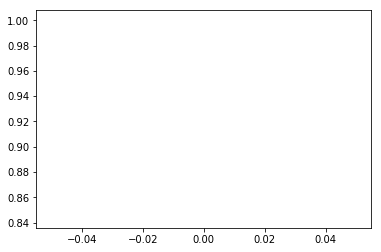

In [6]:
plt.plot(train_accuracy_history);
plt.plot(val_accuracy_history);
# тут считал средюю по точности обучения. 
print(sum(val_accuracy_history)/len(val_accuracy_history))

In [7]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

100%|██████████| 93/93 [00:09<00:00,  9.95it/s]


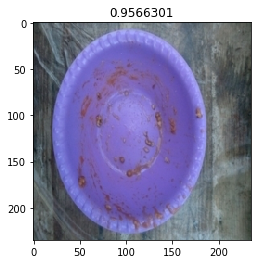

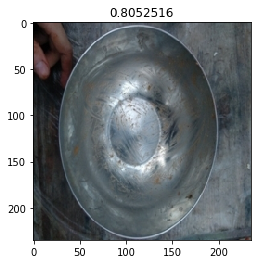

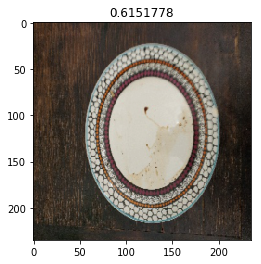

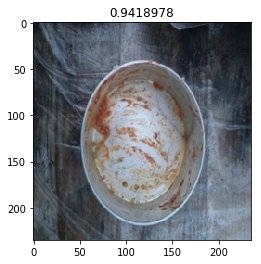

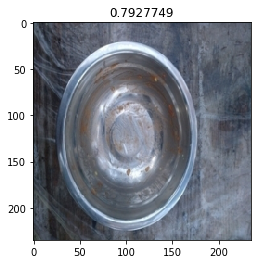

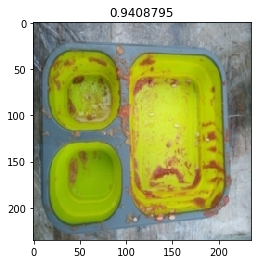

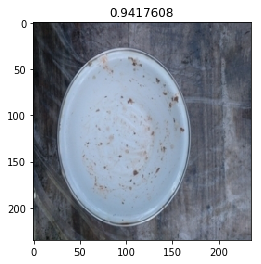

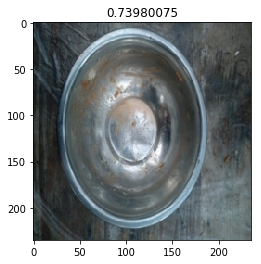

In [31]:
#batch_size = 8
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

custom_model_95.eval()
#model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = custom_model_95(inputs)
        #preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1,_stacklevel=7)[:,1].data.cpu().numpy())
        #torch.nn.functional.gumbel_softmax(preds, dim=1,hard=True,tau=1)[:,1].data.cpu().numpy())
        #torch.nn.functional.log_softmax(preds, dim=1)[:,1].data.cpu().numpy())                   
        #torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
        #torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
        
    
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [36]:
pred_val = 0.615#488 #0.577  #525 #0.525
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions, 'prob':test_predictions})
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > pred_val else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
#submission_df.set_index('prob', inplace=True)
#pd.set_option('display.max_rows',400)

# submission_df['prob']=pred
print(submission_df.loc[submission_df['label']=='cleaned'].mean())
print(submission_df.loc[submission_df['label']=='cleaned'].count())
print('*********')
print(submission_df.label.value_counts())
print('************')
submission_df.loc[submission_df['label']=='cleaned']


prob    0.352848
dtype: float32
label    263
prob     263
dtype: int64
*********
dirty      481
cleaned    263
Name: label, dtype: int64
************


,label,prob
id,,
0009,cleaned,0.370583
0012,cleaned,0.283226
0014,cleaned,0.168110
0024,cleaned,0.271448
0026,cleaned,0.425440
0027,cleaned,0.221779
0030,cleaned,0.466872
0053,cleaned,0.120707
0054,cleaned,0.352953


In [37]:
pd.set_option('display.max_rows',750)
submission_df.sort_values(by=['prob'], ascending=False)

,label,prob
id,,
0547,dirty,0.984729
0149,dirty,0.978736
0133,dirty,0.978430
0138,dirty,0.976770
0043,dirty,0.976728
0479,dirty,0.975116
0418,dirty,0.974695
0554,dirty,0.971794
0237,dirty,0.971730


In [25]:
submission_df.label.value_counts()

dirty      484
cleaned    260
Name: label, dtype: int64

In [26]:
submission_df2 = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
submission_df2['label'] = submission_df2['label'].map(lambda pred: 'dirty' if pred > pred_val else 'cleaned')
submission_df2['id'] = submission_df2['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df2['id'] = submission_df2['id'].str.replace('.jpg', '')
submission_df2.set_index('id', inplace=True)
submission_df2.to_csv('submission.csv')

In [ ]:
torch.save(custom_model_95,"/kaggle/working/097177_adapt_lr")

In [ ]:
pred_val2 = 0.5 #488 #0.577  #525 #0.525
submission_df2 = pd.DataFrame.from_dict({'id': test_img_paths2, 'label': test_predictions2, 'prob':test_predictions2})
submission_df2['label'] = submission_df2['label'].map(lambda pred: 'dirty' if pred > pred_val2 else 'cleaned')
submission_df2['id'] = submission_df2['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df2['id'] = submission_df2['id'].str.replace('.jpg', '')
submission_df2.set_index('id', inplace=True)
#submission_df.set_index('prob', inplace=True)
#pd.set_option('display.max_rows',400)

# submission_df['prob']=pred
print(submission_df2.loc[submission_df['label']=='cleaned'].mean())
print(submission_df2.loc[submission_df['label']=='cleaned'].count())
print('*********')
print(submission_df2.label.value_counts())
print('************')
submission_df2.loc[submission_df2['label']=='cleaned']

In [ ]:
pred_val3 = 0.9 #488 #0.577  #525 #0.525
submission_df3 = pd.DataFrame.from_dict({'id': test_img_paths3, 'label': test_predictions3, 'prob':test_predictions3})
submission_df3['label'] = submission_df3['label'].map(lambda pred: 'dirty' if pred > pred_val3 else 'cleaned')
submission_df3['id'] = submission_df3['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df3['id'] = submission_df3['id'].str.replace('.jpg', '')
submission_df3.set_index('id', inplace=True)
#submission_df.set_index('prob', inplace=True)
#pd.set_option('display.max_rows',400)

# submission_df['prob']=pred
print(submission_df3.loc[submission_df['label']=='cleaned'].mean())
print(submission_df3.loc[submission_df['label']=='cleaned'].count())
print('*********')
print(submission_df3.label.value_counts())
print('************')
submission_df3.loc[submission_df3['label']=='cleaned']
#submission_df3.head()

In [ ]:
total_submission = submission_df3+submission_df2+submission_df
# no_label_subm = total_submission.drop(['label'],axis=1)
# no_label_subm.prob=total_submission.prob/3.
# #no_label_subm.head(20)
# pd.set_option('display.max_rows',400)
# no_label_subm.loc[no_label_subm['prob']<0.6]
total_submission

In [ ]:
total_submission.label.value_counts()
#total_submission.loc[total_submission['label']=='cleaneddirty']

In [ ]:
pred_val3 = 3.5 #488 #0.577  #525 #0.525
submission_dff = pd.DataFrame.from_dict({'id': test_img_paths3, 'label': test_predictions3, 'prob':no_label_subm.prob})
submission_dff['label'] = submission_dff['label'].map(lambda pred: 'dirty' if pred > pred_val3 else 'cleaned')
submission_dff['id'] = submission_dff['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_dff['id'] = submission_dff['id'].str.replace('.jpg', '')
submission_dff.set_index('id', inplace=True)
#submission_df.set_index('prob', inplace=True)
pd.set_option('display.max_rows',750)

# submission_df['prob']=pred
print(submission_dff.loc[submission_df['label']=='cleaned'].mean())
print(submission_dff.loc[submission_df['label']=='cleaned'].count())
print('*********')
print(submission_dff.label.value_counts())
print('************')
submission_dff.loc[submission_dff['label']=='cleaned']
submission_dff.sort_values(by=['prob'])

In [ ]:
#######TRY NEM IMGE PREPROCESSING
import albumentations as albu
from albumentations.pytorch import ToTensor

BORDER_CONSTANT = 0
BORDER_REFLECT = 2

def pre_transforms(image_size=224):
    # Convert the image to a square of size image_size x image_size
    # (keeping aspect ratio)
    result = [
        albu.LongestMaxSize(max_size=image_size),
        albu.PadIfNeeded(image_size, image_size, border_mode=BORDER_CONSTANT)
    ]
    
    return result

def hard_transforms():
    result = [
        # Random shifts, stretches and turns with a 50% probability
        albu.ShiftScaleRotate( 
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=15,
            border_mode=BORDER_REFLECT,
            p=0.5
        ),
        albu.IAAPerspective(scale=(0.02, 0.05), p=0.3),
        # Random brightness / contrast with a 30% probability
        albu.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2, p=0.3
        ),
        # Random gamma changes with a 30% probability
        albu.RandomGamma(gamma_limit=(85, 115), p=0.3),
        # Randomly changes the hue, saturation, and color value of the input image
        albu.HueSaturationValue(p=0.3),
        albu.JpegCompression(quality_lower=80),
    ]
    
    return result

def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]

def compose(transforms_to_compose):
    # combine all augmentations into one single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result





In [ ]:
#****************************************************#
#MYMODEL!
#My models
#print(os.listdir("../input/test-model"))
custom_model_95 = torch.load("../input/test-model/095026",map_location='cpu')
# Disable grad for all conv layers
for param in custom_model_95.parameters():
    param.requires_grad = False

custom_model_95.fc = torch.nn.Linear(custom_model_95.fc.in_features, 2)

weight_tensor = torch.tensor([0.555,0.445])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
custom_model_95 = custom_model_95.to(device)
weight_tensor = weight_tensor.to(device)


loss = torch.nn.CrossEntropyLoss() #weight=weight_tensor
# Долго подбирал параметры оптимайзера и остановился на Адам. 
# Лернинг рейт оставил стандартный но применил amsgrad
optimizer = torch.optim.Adam(model.parameters(), lr=1 *1.0e-3, amsgrad=True)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, nesterov=True) #best
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.14, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.4, centered=False)

# Decay LR by a factor of 0.1 every 7 epochs
# Шудулер пробовал с разными параметрами и шагами. Гамму увелечили до 0.15
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.15)

random.seed(3)
np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)
train_accuracy_history = []
train_loss_history = []
val_accuracy_history = []
val_loss_history = []
train_model(custom_model_95, loss, optimizer, scheduler, num_epochs=1)

In [ ]:
#2.MY_EXPERIMENT_EF__NETT